In [308]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import numpy.linalg as ln
import matplotlib.style as style
from math import sqrt
from matplotlib import cm

In [309]:
style.use('dark_background')

# Задание 1
## Гаусс-Ньютон — реализация

$$S(B) = \sum_{i=1}^N r_i(B)^2, \quad r - residual, \; r_i = Y_i - f(X, B), \quad f(X, B) - current \; prediction$$ <br>
$$B = B - (J_r^TJ_r)^{-1} J_r^T r(B), \quad (J_r^TJ_r)^{-1} J_r^T - pseudoinverse \; of \; J_r$$

In [310]:
class GaussNewton:
    def __init__(self, func, eps, max_iterations):
        self.func = func
        self.eps = eps
        self.max_iterations = max_iterations
        self.X = None
        self.Y = None
        self.B = None

    def fit(self, X, Y, B0):
        self.X = X
        self.Y = Y
        self.B = B0

        error_prev = np.inf
        final_iterations = 0
        for iteration in range(self.max_iterations):
            residual = self.calculateResidual(self.B)
            J = self.calculateJacobian(self.B)
            self.B -= self.pseudoInverse(J) @ residual

            error = np.sqrt(np.sum(residual**2))
            error_diff = np.abs(error_prev - error)
            final_iterations = iteration
            if error_diff < self.eps:
                return self.B, final_iterations

            error_prev = error

        return self.B, final_iterations

    def calculateResidual(self, B):
        Y_cur = self.func(self.X, B)
        return Y_cur - self.Y

    def calculateJacobian(self, B0, step=1e-6):
        Y0 = self.calculateResidual(B0)
        J = []
        for i, parameter in enumerate(B0):
            B = B0.copy()
            B[i] += step
            Y = self.calculateResidual(B)
            derivative = (Y - Y0) / step
            J.append(derivative)
        J = np.array(J).T

        return J

    def pseudoInverse(self, X):
        return np.linalg.inv(X.T @ X) @ X.T

In [311]:
def runGaussNewton(func, N = 30, eps = 1e-15, randCoeff = 2, max_iterations = 1000):
    def generateStartingValues():
        X = np.linspace(1, N * 0.5, N)
        B = np.random.randint(5, size=2) + 1
        Y = func(X, B) + randCoeff * np.random.rand(N)
        return X, B, Y

    print(f"running on function     {func}")

    X, B, Y = generateStartingValues()
    B0 = [0, 0]

    gauss_newton = GaussNewton(func, eps, max_iterations)
    Bf, iterations = gauss_newton.fit(X, Y, B0)

    Xg = np.linspace(1, N * 0.5, 500)
    print(f"actual B:               {B}")
    plt.plot(Xg, func(Xg, B), color='magenta', label='without noise')
    print(f"Finded coefficients:    {Bf}")
    print()

    fig = plt.figure(1, figsize=(6, 4), dpi=120)
    fig.set_size_inches(13, 8)
    plt.scatter(X, Y, color='white')
    plt.plot(Xg, func(Xg, Bf), color='cyan', label='predicted')
    plt.plot(Xg, func(Xg, B0), color='white', label='starting')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"iterations: {iterations}")
    plt.legend()
    plt.show()

## Гаусс-Ньютон — запуск
### Нелинейная регрессия

running on function     <function func1 at 0x1230a3670>
actual B:               [2 3]
Finded coefficients:    [ 2.17606562 13.53927156]

running on function     <function func2 at 0x12ae91ca0>
actual B:               [2 3]
Finded coefficients:    [1.8198781 4.9295303]



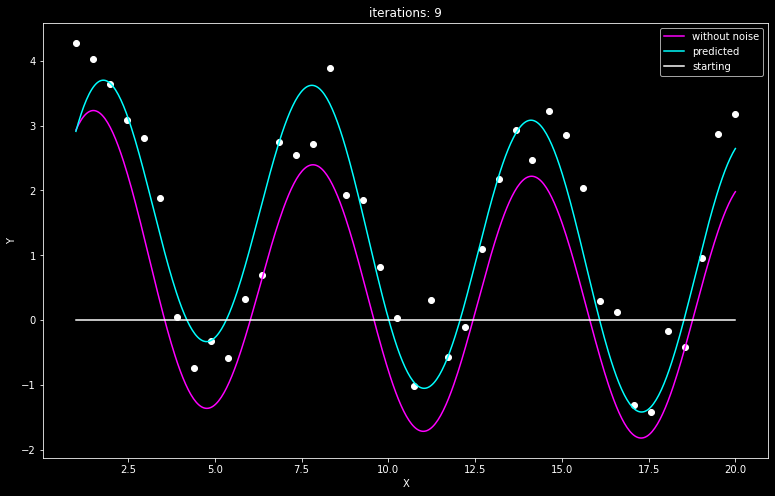

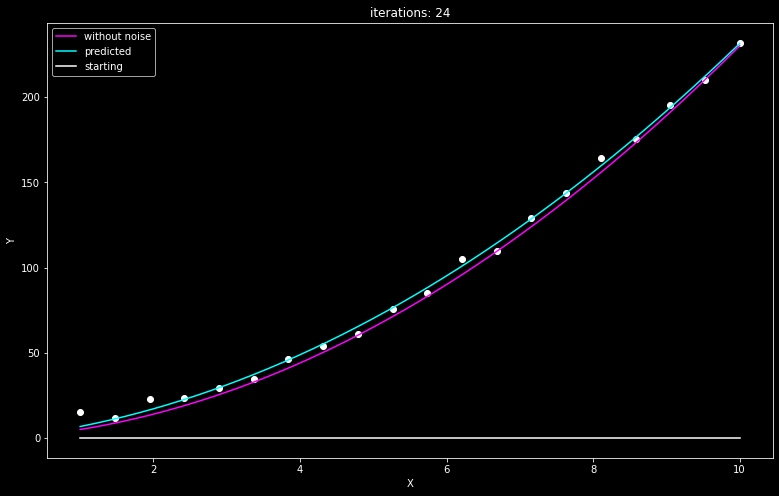

In [312]:
def func1(X, B):
    return (B[0] + B[1] * X) / (X**2 + B[1]) + np.sin(X) * B[0]

runGaussNewton(func1, N=40)

def func2(X, B):
    return B[0] * X**2 + B[1] * X

runGaussNewton(func2, N=20, randCoeff=10)

### Линейная регрессия

running on function     <function func3 at 0x12e01d1f0>
actual B:               [3 5]
Finded coefficients:    [6.65926255 4.84181764]



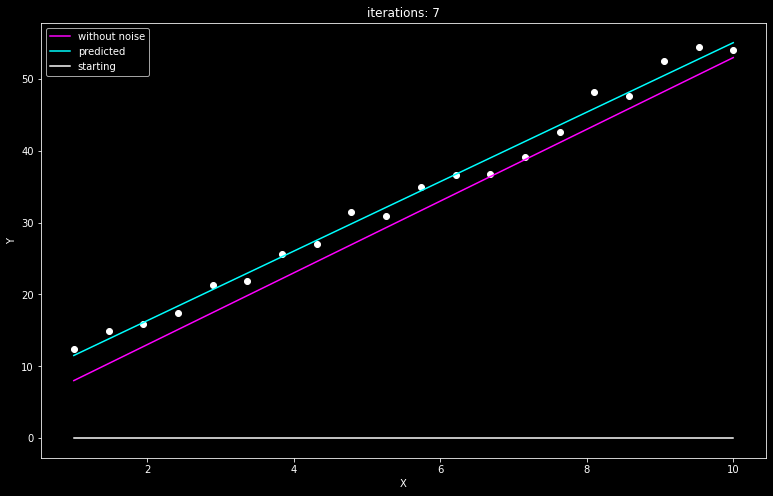

In [313]:
def func3(X, B):
   return B[0] + X * B[1]

runGaussNewton(func3, N=20, randCoeff=5)

## Powell's dogleg — реализация

In [314]:
class DogLeg:
    def __init__(self, function, eps, max_iterations):
        self.function = function
        self.eps = eps
        self.max_iterations = max_iterations
        self.X = None
        self.Y = None
        self.B = None

    def func(self, B):
        return self.function(self.X, B)

    def fit(self, X, Y, B0):
        self.X = X
        self.Y = Y
        self.B = B0

        self.B, iterations = self.trust_region_dogleg(B0)

        return self.B, iterations

    def grad(self, B0):
        J = self.jac(B0)
        r = self.r(B0)
        return 2 * (J.T @ r)

    def hess(self, B0):
        J = self.jac(B0)
        return 2 * (J.T @ J)

    def jac(self, B0, step=1e-6):
        Y0 = self.func(B0)
        J = []
        for i, parameter in enumerate(B0):
            B = B0.copy()
            B[i] += step
            Y = self.func(B)
            derivative = (Y - Y0) / step
            J.append(derivative)
        J = np.array(J).T
        return -J

    def r(self, B):
        return self.Y - self.func(B)

    def dogleg_method(self, Hk, gk, Bk, trust_radius):

        pB = -np.dot(Hk, gk)
        norm_pB = sqrt(np.dot(pB, pB))

        if norm_pB <= trust_radius:
            return pB

        pU = - (np.dot(gk, gk) / np.dot(gk, np.dot(Bk, gk))) * gk
        dot_pU = np.dot(pU, pU)
        norm_pU = sqrt(dot_pU)

        if norm_pU >= trust_radius:
            return trust_radius * pU / norm_pU

        pB_pU = pB - pU
        dot_pB_pU = np.dot(pB_pU, pB_pU)
        dot_pU_pB_pU = np.dot(pU, pB_pU)
        fact = dot_pU_pB_pU ** 2 - dot_pB_pU * (dot_pU - trust_radius ** 2)
        tau = (-dot_pU_pB_pU + sqrt(fact)) / dot_pB_pU

        return pU + tau * pB_pU

    def trust_region_dogleg(self, x0, initial_trust_radius=1.0,
                            max_trust_radius=100.0, eta=0.15, gtol=1e-4,
                            maxiter=100):
        xk = x0
        trust_radius = initial_trust_radius
        iterations = 0
        while True:

            gk = self.grad(xk)
            Bk = self.hess(xk)
            Hk = np.linalg.inv(Bk)
            pk = self.dogleg_method(Hk, gk, Bk, trust_radius)
            act_red = np.sum(self.r(xk)**2) - np.sum(self.r(xk + pk)**2)
            pred_red = -(np.dot(gk, pk) + 0.5 * np.dot(pk, np.dot(Bk, pk)))
            rhok = act_red / pred_red

            if pred_red == 0.0:
                rhok = 1e99
            else:
                rhok = act_red / pred_red

            norm_pk = sqrt(np.dot(pk, pk))

            if rhok < 0.25:
                trust_radius = 0.25 * norm_pk
            else:
                if rhok > 0.75 and norm_pk == trust_radius:
                    trust_radius = min(2.0 * trust_radius, max_trust_radius)
                else:
                    trust_radius = trust_radius

            if rhok > eta:
                xk = xk + pk
            else:
                xk = xk

            if ln.norm(gk) < gtol:
                break

            if iterations >= maxiter:
                break
            iterations = iterations + 1
        return xk, iterations

In [315]:
def runDogLeg(func, N = 30, eps = 1e-15, randCoeff = 2, max_iterations=1000):
    def generateStartingValues():
        X = np.linspace(1, N * 0.5, N)
        B = np.random.randint(5, size=2) + 1
        Y = func(X, B) + randCoeff * np.random.rand(N)
        return X, B, Y

    print(f"running on function     {func}")

    X, B, Y = generateStartingValues()
    B0 = [0, 0]

    dog_leg = DogLeg(func, eps, max_iterations)
    Bf, iterations = dog_leg.fit(X, Y, B0)
    Xg = np.linspace(1, N * 0.5, 500)
    print(f"actual B:               {B}")
    plt.plot(Xg, func(Xg, B), color='magenta', label='without noise')
    print(f"Finded coefficients:    {Bf}")
    print()

    fig = plt.figure(1, figsize=(6, 4), dpi=120)
    fig.set_size_inches(13, 8)
    plt.scatter(X, Y, color='white')
    plt.plot(Xg, func(Xg, Bf), color='cyan', label='predicted')
    plt.plot(Xg, func(Xg, B0), color='white', label='starting')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"iterations: {iterations}")
    plt.legend()
    plt.show()

## Powell's dogleg — запуск
### Нелинейная регрессия

running on function     <function with_sinus at 0x12dd3e160>
actual B:               [3 4]
Finded coefficients:    [ 3.17148079 18.98286974]

running on function     <function parabola at 0x12d97b820>
actual B:               [3 2]
Finded coefficients:    [2.84149289 3.99678482]



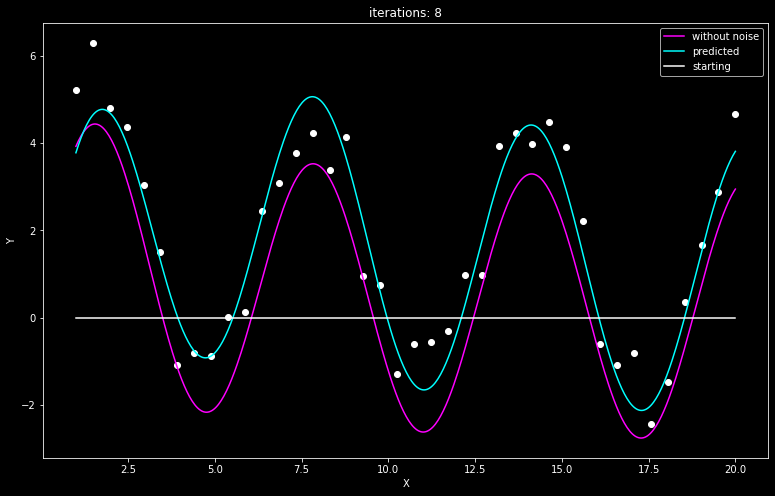

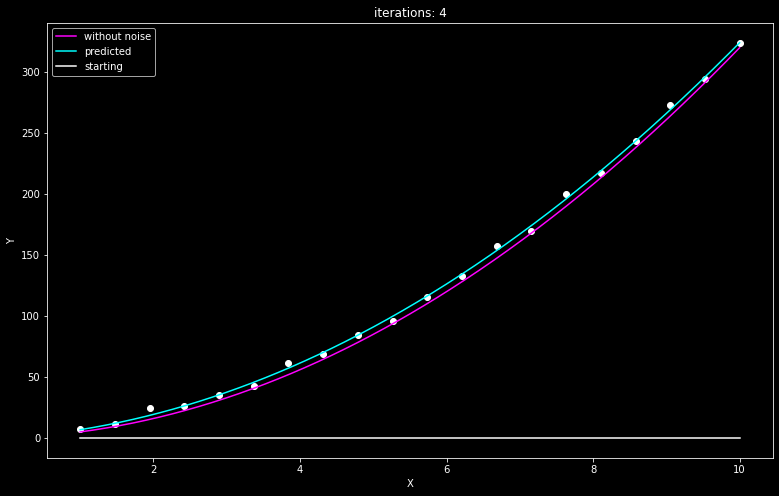

In [316]:
def with_sinus(X, B):
    return (B[0] + B[1] * X) / (X**2 + B[1]) + np.sin(X) * B[0]

runDogLeg(with_sinus, N=40)

def parabola(X, B):
    return B[0] * X ** 2 + B[1] * X

runDogLeg(parabola, N=20, randCoeff=10)

### Линейная регрессия

running on function     <function linear at 0x12af7cee0>
actual B:               [2 5]
Finded coefficients:    [4.79406289 5.06472821]



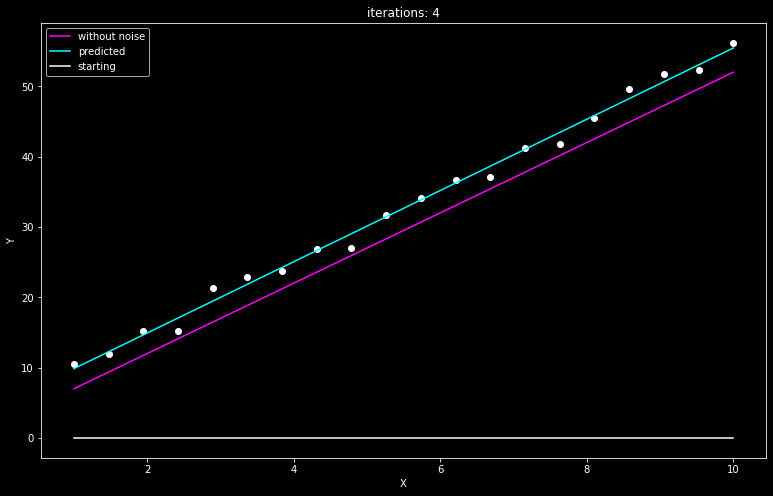

In [317]:
def linear(X, B):
   return B[0] + X * B[1]

runDogLeg(linear, N=20, randCoeff=5)


# Задание 2
## BFGS - реализация

In [318]:
class BFGS:
    def __init__(self, func, grad, eps, max_iterations):
        self.func = func
        self.grad = grad
        self.eps = eps
        self.max_iterations = max_iterations
        self.X = None
        self.Y = None
        self.B = None

    def fit(self, X, Y, B0):
        self.X = X
        self.Y = Y
        self.B = B0

        B_prev = self.B.copy()
        grad_prev = self.grad(self.B)
        iterations = 0
        N = len(self.B)
        I = np.eye(N, dtype='float64')
        H = I

        points = [self.B.copy()]

        while np.linalg.norm(grad_prev) > self.eps and iterations < self.max_iterations:
            p = -np.dot(H, grad_prev)

            line_search = sp.optimize.line_search(self.func, self.grad, self.B, p)
            k = line_search[0]
            print(k * p)
            self.B += k * p
            sk = self.B - B_prev
            B_prev = self.B.copy()

            grad = self.grad(self.B)
            yk = grad - grad_prev
            grad_prev = grad

            iterations += 1
            H = self.nextHessian(H, I, sk, yk)

            points.append(self.B.copy())

        return np.array(points), iterations

    def nextHessian(self, H, I, sk, yk):
        rho = 1.0 / (np.dot(yk, sk))
        A1 = I - rho * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - rho * yk[:, np.newaxis] * sk[np.newaxis, :]
        return np.dot(A1, np.dot(H, A2)) + (rho * sk[:, np.newaxis] * sk[np.newaxis, :])

## BFGS - запуск

[-19.  -4.]
[  3.15348341 -10.70741493]
[2.53011566 6.18083023]
[-0.76094423 -0.4822311 ]
[0.07765447 0.00723571]
[-0.00028757  0.00163104]
[-2.19926523e-05 -5.11075121e-05]


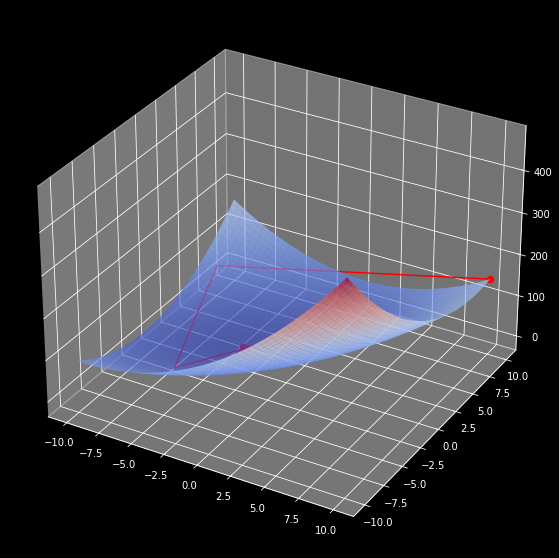

In [319]:
def f(x):
    return x[0]**2 - x[0]*x[1] + x[1]**2 + 9*x[0] - 6*x[1] + 20

def f1(x):
    return np.array([2 * x[0] - x[1] + 9, -x[0] + 2*x[1] - 6])

minValue = -10
maxValue = 10
totalNumber = 100
def getGraph(pointOfDescent, abstractFunction):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = plt.axes(projection='3d')
    x = np.linspace(minValue, maxValue, totalNumber)
    y = np.linspace(minValue, maxValue, totalNumber)
    x, y = np.meshgrid(x, y)
    z = abstractFunction([x, y])
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.7)
    xD, yD = [], []
    for xi, yi in pointOfDescent:
        xD.append(xi)
        yD.append(yi)
    xD = np.array(xD)
    yD = np.array(yD)
    zD = abstractFunction([xD, yD])

    for i in range(1, len(xD)):
        ax.plot([xD[i], xD[i - 1]], [yD[i], yD[i - 1]], zs=[zD[i], zD[i - 1]], color='red')
    ax.scatter(xD[0], yD[0], zD[0], linewidths=3, color='red')
    ax.scatter(xD[len(xD) - 1], yD[len(yD) - 1], zD[len(zD) - 1], linewidths=3, color='red')
    plt.show()

bfgs_solver = BFGS(f, f1, eps=1e-6, max_iterations=1000)
X0 = np.array([maxValue, maxValue], dtype='float64')
points, iterations = bfgs_solver.fit([], [], X0)
getGraph(points, f)